In [ ]:
#default_exp audio.model
#default_cls_lvl 3

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from local.core import *
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.optimizer import *
from local.metrics import *
from local.vision.learner import *
from local.audio.core import *
from local.notebook.showdoc import *

In [ ]:
url = URLs.ESC50_SAMPLE

In [ ]:
path = untar_data(url)

In [ ]:
path = Path.home()/".fastai"/"data"/"master"/"ESC-50-master"/"audio"

In [ ]:
path

PosixPath('/home/kbird/.fastai/data/master/ESC-50-master/audio')

In [ ]:
items = get_audio_files(path)

In [ ]:
split_idx = RandomSplitter()(items)

In [ ]:
mel_args = {'sample_rate': 44100, 'n_fft': 2560}

In [ ]:
pipe_audio = Pipeline([AudioSignal.create, MelSpectrogramify(**mel_args), AmplitudeToDBify()], as_item=True)

In [ ]:
pipe_audio(items[0])

tensor([[[ 19.9262,  26.1792,  19.7233,  ...,  19.1721,  16.3122,  19.5270],
         [ 18.0439,  20.4803,  20.5529,  ...,  20.8349,  16.7609,  14.2495],
         [ 21.0154,  23.5795,  24.0690,  ...,  18.2519,  17.7518,  19.2528],
         ...,
         [-38.8462, -55.6684, -56.3198,  ..., -56.8876, -40.8654, -32.1484],
         [-34.2004, -56.0750, -54.6879,  ..., -56.7633, -55.7205, -32.6729],
         [-34.6933, -54.0305, -55.2806,  ..., -56.8744, -55.4135, -32.9107]]])

In [ ]:
def labeller(o, **kwargs):
    return labels[labels.filename==o.name]["category"].values[0]

In [ ]:
labels = pd.read_csv(Path.home()/".fastai/data/master/ESC-50-master/meta/esc50.csv")

In [ ]:
labels

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [ ]:
class PetAudioTfm(Transform):
    def __init__(self, items, train_idx):
        self.items,self.train_idx = items,train_idx
        self.labeller = labeller
        vals = map(self.labeller, items[train_idx])
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, i):
        o = self.items[i]
        return pipe_audio(o), self.o2i[self.labeller(o)]
    
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

In [ ]:
pets = DataBlock(types=(AudioSpectrogram, Category), 
          get_items=get_audio_files, 
          splitter=RandomSplitter(), 
          get_y=labeller
         )

In [ ]:
dbunch = pets.databunch(path, item_tfms=pipe_audio, bs=4)

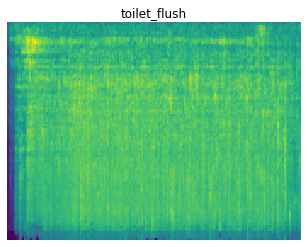

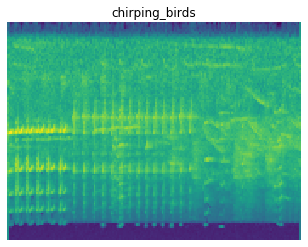

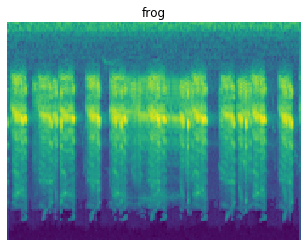

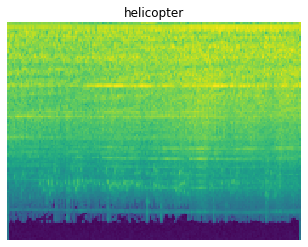

In [ ]:
dbunch.show_batch()

In [ ]:
from torch.nn import Conv2d, Sequential, Module

In [ ]:
from torchvision.models import resnet34

In [ ]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)

In [ ]:
learn = cnn_learner(dbunch, resnet34, opt_func=opt_func, metrics=[accuracy, error_rate], path=Path("~/.fastai"))

In [ ]:
learn.model[0][0].in_channels=1

In [ ]:
learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

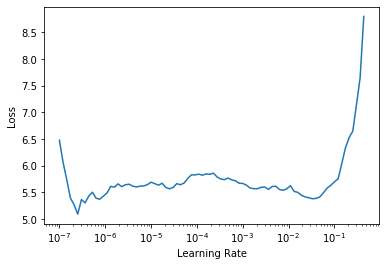

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-3)

RuntimeError: CUDA error: an illegal memory access was encountered

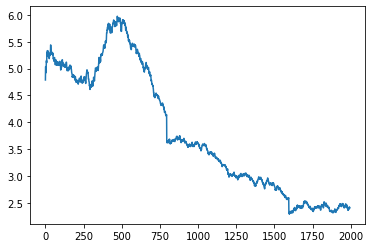

In [ ]:
learn.recorder.plot_loss()

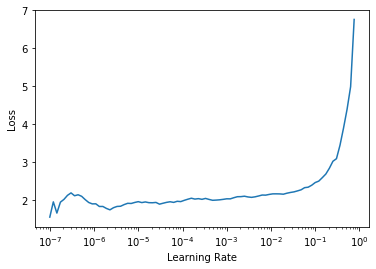

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.275184,1.802344,0.457500,0.542500,00:11
1,2.255978,1.604450,0.565000,0.435000,00:11
2,1.997015,1.402605,0.595000,0.405000,00:11
3,1.825710,1.293424,0.627500,0.372500,00:11
4,1.740333,1.372040,0.597500,0.402500,00:11


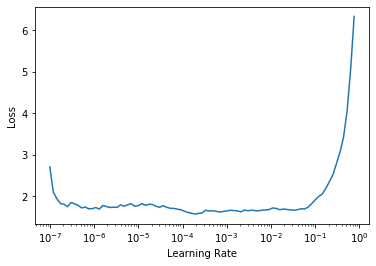

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.761897,4.300833,0.090000,0.910000,00:11
1,4.432916,499688306376704.000000,0.080000,0.920000,00:11
2,4.257029,83.153595,0.090000,0.910000,00:11
3,3.764623,5.047360,0.225000,0.775000,00:11
4,3.246228,11.332150,0.267500,0.732500,00:11


In [ ]:
learn.fit_one_cycle(50, 2e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.156911,7.596677,0.245000,0.755000,00:11
1,3.088593,27.476013,0.275000,0.725000,00:11
2,3.137743,4.603323,0.280000,0.720000,00:11
3,3.083713,24.870760,0.262500,0.737500,00:11
4,3.096110,38314712.000000,0.282500,0.717500,00:11
5,3.137695,12.585833,0.197500,0.802500,00:11
6,3.333131,16.486256,0.237500,0.762500,00:11
7,3.591937,37.545929,0.172500,0.827500,00:11
8,3.977010,16.844172,0.175000,0.825000,00:11
9,4.201114,9.145920,0.105000,0.895000,00:11


In [ ]:
preds, targs = learn.get_preds()

In [ ]:
preds.argmax(dim=1)

tensor([24,  3, 11, 31, 39, 23, 41, 22, 24, 12, 33,  8, 24, 44, 16, 42, 17,  8,
        23, 33, 26, 11,  0,  0, 39, 38,  1, 43, 24, 38, 16, 23, 36, 22,  2, 39,
        12, 13, 15, 22, 23, 36, 21, 46,  0,  2, 41,  3,  5, 11, 15, 41, 11, 48,
        11, 13,  9, 14, 43,  1, 43,  5, 43, 24, 32, 11, 26, 36, 17, 21,  0, 23,
        16, 47, 31, 16,  6,  1, 45,  3, 23, 19, 10, 43, 11,  8, 24,  0, 39, 11,
         8, 26, 27, 28, 19, 15, 27,  4, 24, 46, 45, 45, 16,  5,  0, 23,  9, 31,
        49,  7, 22,  7, 23, 44,  9, 49, 48, 16, 20, 45,  1, 38, 46,  9, 27, 34,
        30, 15, 11, 17, 11, 23, 39, 33, 40, 37, 43, 43,  8, 43, 33, 30, 19, 10,
         2, 31, 25, 43, 41,  1, 24, 36, 20, 23, 20, 39, 32, 34, 25, 46,  6,  3,
        22, 13, 42, 38,  4, 33, 18, 39, 33, 43,  5, 19, 31,  8, 36, 43,  6, 35,
        24, 39, 18, 19,  2,  0, 32, 27, 40,  6, 23, 21, 42, 16,  4, 42, 11, 36,
        35, 32, 24, 24, 34, 44, 16, 46, 41, 26, 19,  1, 36, 11, 22, 23, 15, 36,
        38,  7, 22,  2, 46, 39, 14, 13, 

In [ ]:
targs

tensor([47,  3, 11, 33,  5, 23, 41, 28, 24, 41, 33,  4, 21, 44, 37, 47, 17,  8,
        20, 33, 26, 11, 28,  0, 17, 38,  1, 43, 24, 38, 16, 48, 22, 22,  2, 13,
        29, 13, 28, 28, 11, 36, 41, 46, 45,  2, 18, 31,  5,  3, 15,  5, 11, 35,
        33, 13,  9, 14, 43, 10, 43, 37, 42, 24, 29, 24, 26, 36, 17, 41, 45, 20,
         1, 47, 31, 16,  3, 13, 34,  3, 20, 19, 10, 43, 11, 40,  3,  0, 16, 31,
         8, 12, 27, 22,  5, 15, 27,  4, 24, 47, 45, 45, 15,  5,  4, 23,  9, 11,
        49,  7, 45, 29, 19, 44, 27, 45, 32, 16, 20, 47,  1, 38, 46, 18, 27, 34,
        30,  7, 33, 17, 29, 23, 39, 33, 40, 37, 43, 43,  8, 45,  3, 30, 32, 10,
        35, 31, 25, 49, 21,  6, 24, 36, 20, 23, 20, 39, 29, 34, 25, 46,  6, 33,
         4, 30, 16, 38,  5, 33, 18, 32, 48, 49,  5, 19, 31,  8, 36, 43,  6, 35,
         9, 13, 18, 32,  2,  0, 32, 27, 40,  6, 23, 41, 42, 16,  4, 42, 11, 36,
        35, 29, 45, 34, 34, 44, 37, 46,  3,  4, 10,  1, 36, 11, 47, 23, 25, 36,
        43,  7, 22,  2, 46, 39,  2, 13, 

In [ ]:
learn.dbunch.valid_ds[-1].show

In [ ]:
AudioSignal.create(learn.dbunch.valid_ds[-1][0]).show()